In [1]:
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
import numpy as np
print( f"NumPy {np.__version__}\n" )
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam
from show_predicted_img import show_predicted_img

TensorFlow 2.13.0
tf.keras.backend.image_data_format() = channels_last
NumPy 1.23.2



In [2]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
# np.random.seed(1234)
# tf.random.set_seed(5678)

In [4]:
PATH = 'dataset/train/'

In [5]:
train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 576 files for training.
['caribou', 'deer', 'elk', 'moose']


2023-11-04 22:33:40.589219: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-04 22:33:40.589244: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-04 22:33:40.589252: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-04 22:33:40.589514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-04 22:33:40.589548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [7]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


In [8]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [9]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [10]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

2023-11-04 22:33:43.412130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


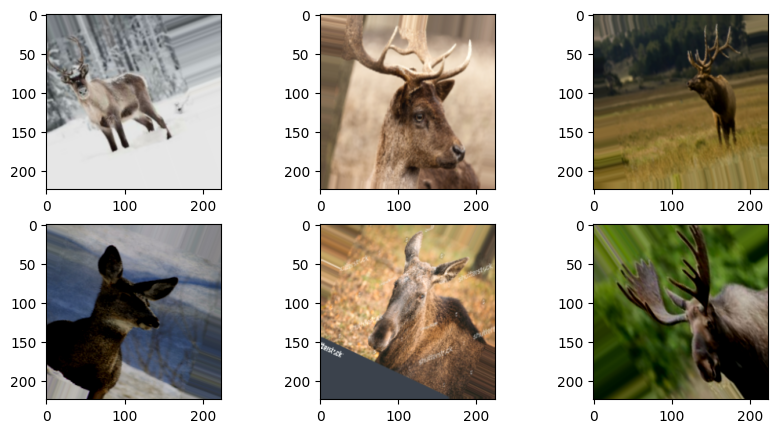

In [11]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [12]:
full_train_ds = train_ds.concatenate(augmented_train)

In [13]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

2023-11-04 22:33:50.684091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1152


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [16]:
base_model = ResNet152V2(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet"
                         )
base_model.trainable = False
# for layer in base_model.layers:
#     # if layer.name in ['conv5_block3_3_conv']:
#     #     layer.trainable = True
    # if "BatchNormalization" in layer.__class__.__name__:
    #     layer.trainable = True

In [17]:
# Fine-tune from this layer onwards
start_tune = 528
stop_tune = 561


for layer in base_model.layers[start_tune:stop_tune]:
  layer.trainable = True

# for layer in base_model.layers:
#   if layer.__class__.__name__ in ["BatchNormalization"]:
#     layer.trainable = True

In [18]:
for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = False
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = False
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = False
Layer 18: name = conv2_block2_p

In [19]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [20]:
# tf.keras.utils.plot_model(base_model, to_file='resnet_feature.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [21]:
base_model_output = base_model.output

x = tf.keras.layers.Flatten()(base_model_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=new_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [22]:
for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = False
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = False
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = False
Layer 18: name = conv2_block2_p

In [23]:
# Defining Callbacks

checkpoint_filepath = "resnet_callback/bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.h5"
early_stop_patience = 60
reduce_lr_patience = 20
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = early_stop_patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                save_weights_only=False, 
                                verbose = 1,
                                option = tf.saved_model.SaveOptions)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=reduce_lr_patience, min_lr=0.00005,verbose=1)
callback_list = [earlystopping, checkpoint,reduce_lr]

In [24]:
# Model Compile 
lr = 0.0001
OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
# OPT    = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr)
# OPT = tf.keras.optimizers.legacy.Adagrad(learning_rate=lr)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [25]:
epoch = 80
model_history=model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs = epoch,
                        callbacks = callback_list,
                        verbose = 2)

Epoch 1/80


2023-11-04 22:34:05.313119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-04 22:34:35.548574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-04 22:34:48.188564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.16759, saving model to resnet_callback/bestmodel_epoch01_valloss1.17.h5


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 - 66s - loss: 1.8261 - accuracy: 0.4644 - val_loss: 1.1676 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 66s/epoch - 2s/step
Epoch 2/80


2023-11-04 22:35:12.636535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 1.16759 to 0.56426, saving model to resnet_callback/bestmodel_epoch02_valloss0.56.h5
36/36 - 19s - loss: 1.2420 - accuracy: 0.6128 - val_loss: 0.5643 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 532ms/step
Epoch 3/80


2023-11-04 22:35:31.882309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss improved from 0.56426 to 0.45616, saving model to resnet_callback/bestmodel_epoch03_valloss0.46.h5
36/36 - 19s - loss: 1.0944 - accuracy: 0.6406 - val_loss: 0.4562 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 19s/epoch - 532ms/step
Epoch 4/80


2023-11-04 22:35:50.950517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss did not improve from 0.45616
36/36 - 17s - loss: 1.0536 - accuracy: 0.6476 - val_loss: 0.4845 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 5/80


2023-11-04 22:36:08.374048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss improved from 0.45616 to 0.43077, saving model to resnet_callback/bestmodel_epoch05_valloss0.43.h5
36/36 - 19s - loss: 0.9525 - accuracy: 0.6684 - val_loss: 0.4308 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 523ms/step
Epoch 6/80


2023-11-04 22:36:27.281692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.9400 - accuracy: 0.6571 - val_loss: 0.4513 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 7/80


2023-11-04 22:36:44.685777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 7: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.8779 - accuracy: 0.6771 - val_loss: 0.4685 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 17s/epoch - 482ms/step
Epoch 8/80


2023-11-04 22:37:02.057499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 8: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.8780 - accuracy: 0.6701 - val_loss: 0.4798 - val_accuracy: 0.8281 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 9/80


2023-11-04 22:37:19.585428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 9: val_loss did not improve from 0.43077
36/36 - 18s - loss: 0.8425 - accuracy: 0.6623 - val_loss: 0.4471 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 18s/epoch - 488ms/step
Epoch 10/80


2023-11-04 22:37:37.141860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 10: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.8782 - accuracy: 0.6788 - val_loss: 0.5083 - val_accuracy: 0.7812 - lr: 1.0000e-04 - 17s/epoch - 483ms/step
Epoch 11/80


2023-11-04 22:37:54.529575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 11: val_loss did not improve from 0.43077
36/36 - 18s - loss: 0.8036 - accuracy: 0.6875 - val_loss: 0.5102 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 18s/epoch - 490ms/step
Epoch 12/80


2023-11-04 22:38:12.201934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 12: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.7667 - accuracy: 0.6849 - val_loss: 0.4683 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 13/80


2023-11-04 22:38:29.677225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 13: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.7819 - accuracy: 0.6875 - val_loss: 0.4759 - val_accuracy: 0.8125 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 14/80


2023-11-04 22:38:47.171498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 14: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.7796 - accuracy: 0.6944 - val_loss: 0.4324 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 15/80


2023-11-04 22:39:04.652190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 15: val_loss did not improve from 0.43077
36/36 - 17s - loss: 0.7209 - accuracy: 0.7014 - val_loss: 0.4992 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 16/80


2023-11-04 22:39:22.099306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 16: val_loss improved from 0.43077 to 0.38877, saving model to resnet_callback/bestmodel_epoch16_valloss0.39.h5
36/36 - 19s - loss: 0.7604 - accuracy: 0.6875 - val_loss: 0.3888 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 531ms/step
Epoch 17/80


2023-11-04 22:39:41.243579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 17: val_loss did not improve from 0.38877
36/36 - 17s - loss: 0.7161 - accuracy: 0.6997 - val_loss: 0.4044 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 18/80


2023-11-04 22:39:58.674581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 18: val_loss improved from 0.38877 to 0.32882, saving model to resnet_callback/bestmodel_epoch18_valloss0.33.h5
36/36 - 19s - loss: 0.7422 - accuracy: 0.6927 - val_loss: 0.3288 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 538ms/step
Epoch 19/80


2023-11-04 22:40:18.170292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 19: val_loss improved from 0.32882 to 0.30193, saving model to resnet_callback/bestmodel_epoch19_valloss0.30.h5
36/36 - 19s - loss: 0.7098 - accuracy: 0.7109 - val_loss: 0.3019 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 535ms/step
Epoch 20/80


2023-11-04 22:40:37.398697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 20: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6870 - accuracy: 0.7161 - val_loss: 0.3078 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 487ms/step
Epoch 21/80


2023-11-04 22:40:54.886557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 21: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6642 - accuracy: 0.7161 - val_loss: 0.3105 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 22/80


2023-11-04 22:41:12.363555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 22: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6858 - accuracy: 0.7231 - val_loss: 0.3229 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 483ms/step
Epoch 23/80


2023-11-04 22:41:29.769768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 23: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6839 - accuracy: 0.7188 - val_loss: 0.3304 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 24/80


2023-11-04 22:41:47.303853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 24: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6666 - accuracy: 0.7240 - val_loss: 0.3456 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 25/80


2023-11-04 22:42:04.738288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 25: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6501 - accuracy: 0.7205 - val_loss: 0.3067 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 490ms/step
Epoch 26/80


2023-11-04 22:42:22.422197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 26: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6586 - accuracy: 0.7257 - val_loss: 0.3522 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 27/80


2023-11-04 22:42:39.934209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 27: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6707 - accuracy: 0.7205 - val_loss: 0.3191 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 487ms/step
Epoch 28/80


2023-11-04 22:42:57.501488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 28: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6862 - accuracy: 0.7231 - val_loss: 0.3366 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 29/80


2023-11-04 22:43:14.976639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 29: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6691 - accuracy: 0.7318 - val_loss: 0.3077 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 30/80


2023-11-04 22:43:32.416061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 30: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6413 - accuracy: 0.7378 - val_loss: 0.3203 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 483ms/step
Epoch 31/80


2023-11-04 22:43:49.864569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 31: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6589 - accuracy: 0.7214 - val_loss: 0.4056 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 483ms/step
Epoch 32/80


2023-11-04 22:44:07.268553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 32: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6261 - accuracy: 0.7483 - val_loss: 0.3509 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 483ms/step
Epoch 33/80


2023-11-04 22:44:24.643673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 33: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6164 - accuracy: 0.7344 - val_loss: 0.3488 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 483ms/step
Epoch 34/80


2023-11-04 22:44:42.040394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 34: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6118 - accuracy: 0.7465 - val_loss: 0.3697 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 35/80


2023-11-04 22:44:59.494903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 35: val_loss did not improve from 0.30193
36/36 - 17s - loss: 0.6127 - accuracy: 0.7292 - val_loss: 0.3386 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 36/80


2023-11-04 22:45:16.970019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 36: val_loss did not improve from 0.30193
36/36 - 18s - loss: 0.6059 - accuracy: 0.7413 - val_loss: 0.3090 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 489ms/step
Epoch 37/80


2023-11-04 22:45:34.598609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 37: val_loss improved from 0.30193 to 0.29966, saving model to resnet_callback/bestmodel_epoch37_valloss0.30.h5
36/36 - 19s - loss: 0.6321 - accuracy: 0.7387 - val_loss: 0.2997 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 533ms/step
Epoch 38/80


2023-11-04 22:45:53.843366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 38: val_loss did not improve from 0.29966
36/36 - 18s - loss: 0.6289 - accuracy: 0.7378 - val_loss: 0.3006 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 488ms/step
Epoch 39/80


2023-11-04 22:46:11.325260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 39: val_loss did not improve from 0.29966
36/36 - 17s - loss: 0.5979 - accuracy: 0.7405 - val_loss: 0.3020 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 40/80


2023-11-04 22:46:28.804037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 40: val_loss improved from 0.29966 to 0.29383, saving model to resnet_callback/bestmodel_epoch40_valloss0.29.h5
36/36 - 19s - loss: 0.6145 - accuracy: 0.7266 - val_loss: 0.2938 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 528ms/step
Epoch 41/80


2023-11-04 22:46:47.903402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 41: val_loss did not improve from 0.29383
36/36 - 17s - loss: 0.5938 - accuracy: 0.7405 - val_loss: 0.3489 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 486ms/step
Epoch 42/80


2023-11-04 22:47:05.337193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 42: val_loss improved from 0.29383 to 0.28228, saving model to resnet_callback/bestmodel_epoch42_valloss0.28.h5
36/36 - 19s - loss: 0.5899 - accuracy: 0.7491 - val_loss: 0.2823 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 527ms/step
Epoch 43/80


2023-11-04 22:47:24.410666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 43: val_loss did not improve from 0.28228
36/36 - 18s - loss: 0.6071 - accuracy: 0.7318 - val_loss: 0.3205 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 44/80


2023-11-04 22:47:41.845261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 44: val_loss did not improve from 0.28228
36/36 - 17s - loss: 0.5573 - accuracy: 0.7500 - val_loss: 0.2827 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 45/80


2023-11-04 22:47:59.324075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 45: val_loss did not improve from 0.28228
36/36 - 17s - loss: 0.5752 - accuracy: 0.7578 - val_loss: 0.2852 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 46/80


2023-11-04 22:48:16.819273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 46: val_loss did not improve from 0.28228
36/36 - 17s - loss: 0.5905 - accuracy: 0.7448 - val_loss: 0.2953 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 47/80


2023-11-04 22:48:34.288371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 47: val_loss improved from 0.28228 to 0.27628, saving model to resnet_callback/bestmodel_epoch47_valloss0.28.h5
36/36 - 19s - loss: 0.5729 - accuracy: 0.7561 - val_loss: 0.2763 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 524ms/step
Epoch 48/80


2023-11-04 22:48:53.279586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 48: val_loss improved from 0.27628 to 0.27269, saving model to resnet_callback/bestmodel_epoch48_valloss0.27.h5
36/36 - 19s - loss: 0.5618 - accuracy: 0.7561 - val_loss: 0.2727 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 19s/epoch - 530ms/step
Epoch 49/80


2023-11-04 22:49:12.346050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 49: val_loss did not improve from 0.27269
36/36 - 17s - loss: 0.5373 - accuracy: 0.7630 - val_loss: 0.2744 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 486ms/step
Epoch 50/80


2023-11-04 22:49:29.753907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 50: val_loss did not improve from 0.27269
36/36 - 17s - loss: 0.5446 - accuracy: 0.7674 - val_loss: 0.2927 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 51/80


2023-11-04 22:49:47.233274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 51: val_loss did not improve from 0.27269
36/36 - 17s - loss: 0.5884 - accuracy: 0.7561 - val_loss: 0.3091 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 52/80


2023-11-04 22:50:04.720647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 52: val_loss did not improve from 0.27269
36/36 - 18s - loss: 0.5536 - accuracy: 0.7726 - val_loss: 0.3195 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 487ms/step
Epoch 53/80


2023-11-04 22:50:22.332052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 53: val_loss did not improve from 0.27269
36/36 - 18s - loss: 0.5911 - accuracy: 0.7387 - val_loss: 0.2878 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 488ms/step
Epoch 54/80


2023-11-04 22:50:39.825939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 54: val_loss did not improve from 0.27269
36/36 - 17s - loss: 0.5621 - accuracy: 0.7639 - val_loss: 0.2765 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 55/80


2023-11-04 22:50:57.301647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 55: val_loss did not improve from 0.27269
36/36 - 17s - loss: 0.5304 - accuracy: 0.7891 - val_loss: 0.2826 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 56/80


2023-11-04 22:51:14.762696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 56: val_loss did not improve from 0.27269
36/36 - 18s - loss: 0.5589 - accuracy: 0.7552 - val_loss: 0.3222 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 487ms/step
Epoch 57/80


2023-11-04 22:51:32.330265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 57: val_loss did not improve from 0.27269
36/36 - 17s - loss: 0.5541 - accuracy: 0.7552 - val_loss: 0.3255 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 58/80


2023-11-04 22:51:49.772755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 58: val_loss did not improve from 0.27269
36/36 - 18s - loss: 0.5568 - accuracy: 0.7552 - val_loss: 0.3250 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 59/80


2023-11-04 22:52:07.320324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 59: val_loss did not improve from 0.27269
36/36 - 18s - loss: 0.5393 - accuracy: 0.7769 - val_loss: 0.3164 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 487ms/step
Epoch 60/80


2023-11-04 22:52:24.862185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 60: val_loss improved from 0.27269 to 0.27205, saving model to resnet_callback/bestmodel_epoch60_valloss0.27.h5
36/36 - 19s - loss: 0.5557 - accuracy: 0.7569 - val_loss: 0.2720 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 19s/epoch - 532ms/step
Epoch 61/80


2023-11-04 22:52:44.109114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 61: val_loss did not improve from 0.27205
36/36 - 18s - loss: 0.5594 - accuracy: 0.7552 - val_loss: 0.3139 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 487ms/step
Epoch 62/80


2023-11-04 22:53:01.558932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 62: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5041 - accuracy: 0.7969 - val_loss: 0.2928 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 486ms/step
Epoch 63/80


2023-11-04 22:53:19.064146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 63: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5334 - accuracy: 0.7760 - val_loss: 0.3054 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 64/80


2023-11-04 22:53:36.536545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 64: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5484 - accuracy: 0.7708 - val_loss: 0.2934 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 65/80


2023-11-04 22:53:53.996365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 65: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5194 - accuracy: 0.7951 - val_loss: 0.2938 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 66/80


2023-11-04 22:54:11.470588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 66: val_loss did not improve from 0.27205
36/36 - 18s - loss: 0.5411 - accuracy: 0.7743 - val_loss: 0.3307 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 18s/epoch - 489ms/step
Epoch 67/80


2023-11-04 22:54:29.074231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 67: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5328 - accuracy: 0.7839 - val_loss: 0.3357 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 68/80


2023-11-04 22:54:46.546234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 68: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5552 - accuracy: 0.7752 - val_loss: 0.3391 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 486ms/step
Epoch 69/80


2023-11-04 22:55:04.043766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 69: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5320 - accuracy: 0.7769 - val_loss: 0.3564 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 70/80


2023-11-04 22:55:21.515759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 70: val_loss did not improve from 0.27205
36/36 - 18s - loss: 0.5232 - accuracy: 0.7847 - val_loss: 0.3383 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 71/80


2023-11-04 22:55:39.038063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 71: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5251 - accuracy: 0.7873 - val_loss: 0.3426 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 72/80


2023-11-04 22:55:56.464586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 72: val_loss did not improve from 0.27205
36/36 - 18s - loss: 0.4989 - accuracy: 0.8099 - val_loss: 0.3608 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 18s/epoch - 486ms/step
Epoch 73/80


2023-11-04 22:56:14.002367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 73: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5091 - accuracy: 0.7760 - val_loss: 0.3602 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 484ms/step
Epoch 74/80


2023-11-04 22:56:31.428471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 74: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5026 - accuracy: 0.7830 - val_loss: 0.3476 - val_accuracy: 0.9062 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 75/80


2023-11-04 22:56:48.908279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 75: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5003 - accuracy: 0.8056 - val_loss: 0.3351 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 486ms/step
Epoch 76/80


2023-11-04 22:57:06.419620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 76: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.5033 - accuracy: 0.7960 - val_loss: 0.3406 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 77/80


2023-11-04 22:57:23.901461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 77: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.4902 - accuracy: 0.8090 - val_loss: 0.3700 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 78/80


2023-11-04 22:57:41.370054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 78: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.4859 - accuracy: 0.8090 - val_loss: 0.3773 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 79/80


2023-11-04 22:57:58.827120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 79: val_loss did not improve from 0.27205
36/36 - 17s - loss: 0.4968 - accuracy: 0.7995 - val_loss: 0.3646 - val_accuracy: 0.8906 - lr: 1.0000e-04 - 17s/epoch - 485ms/step
Epoch 80/80


2023-11-04 22:58:16.319243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 80: val_loss did not improve from 0.27205

Epoch 80: ReduceLROnPlateau reducing learning rate to 5e-05.
36/36 - 17s - loss: 0.5223 - accuracy: 0.7760 - val_loss: 0.3896 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 17s/epoch - 486ms/step


In [26]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

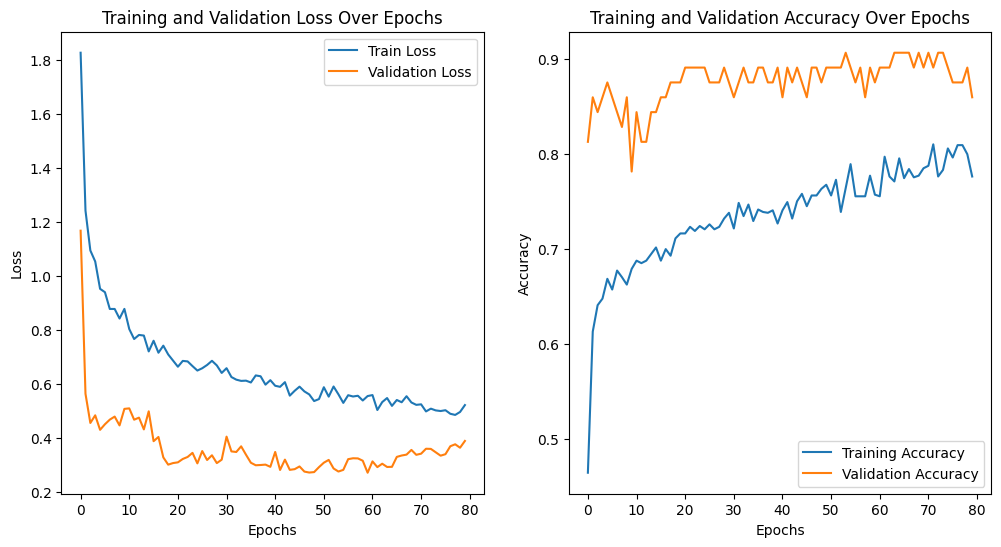

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [28]:
test_result = model.evaluate(test_dataset)
print(f'{model.metrics_names}: {test_result}')

5/5 [==============================] - 2s 330ms/step - loss: 0.3906 - accuracy: 0.8562
['loss', 'accuracy']: [0.39058923721313477, 0.856249988079071]


In [29]:
model_path = "resnet_callback/train_conv5_bestmodel_epoch63_nopool_valloss0.29.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-04 22:58:38.791016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 21s 339ms/step - loss: 0.3094 - accuracy: 0.8938
['loss', 'accuracy']: [0.30936044454574585, 0.893750011920929]


In [46]:
model_path = "resnet_callback/train_conv5_bestmodel_epoch60_nopool_valloss0.27.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-04 23:04:59.608339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 29s 429ms/step - loss: 0.3553 - accuracy: 0.8938
['loss', 'accuracy']: [0.3552975058555603, 0.893750011920929]


In [30]:
loaded_model.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                           

In [31]:
last_conv_layer_name = "conv5_block3_out"

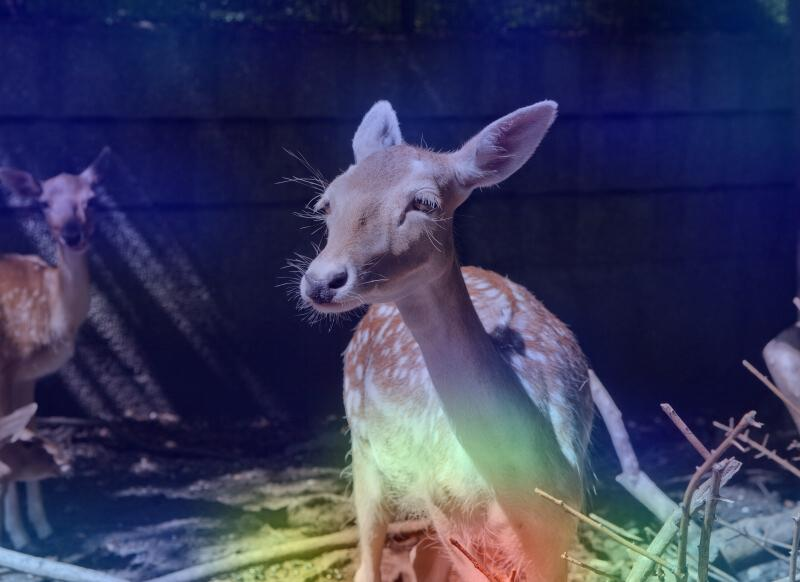

In [32]:
grad_cam_img_path = 'dataset/train/deer/fallow_deer_4.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

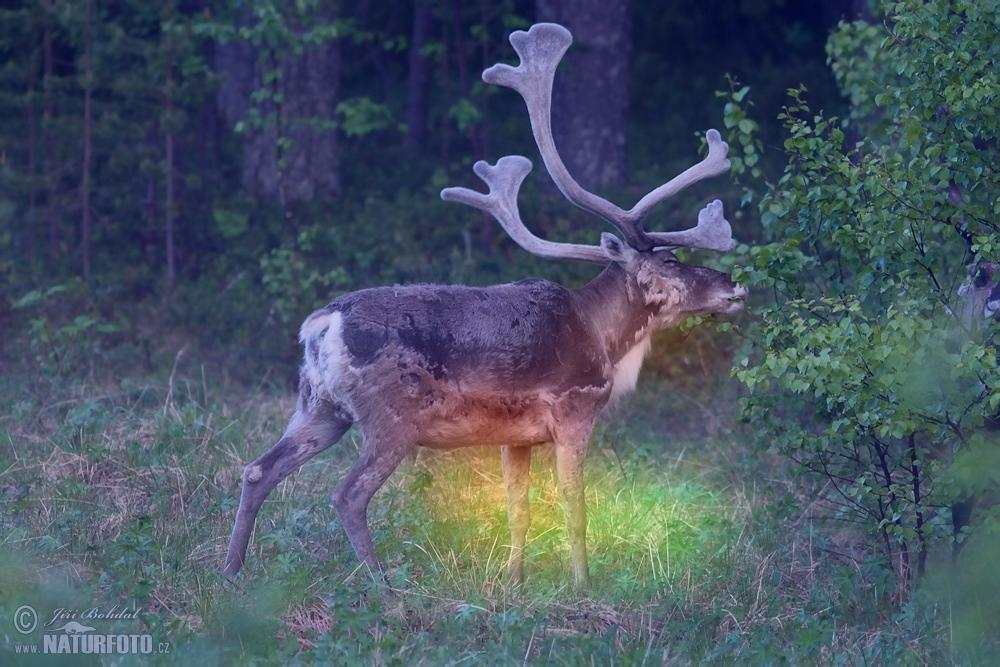

In [33]:
grad_cam_img_path = 'dataset/train/caribou/Male_Caribou56.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

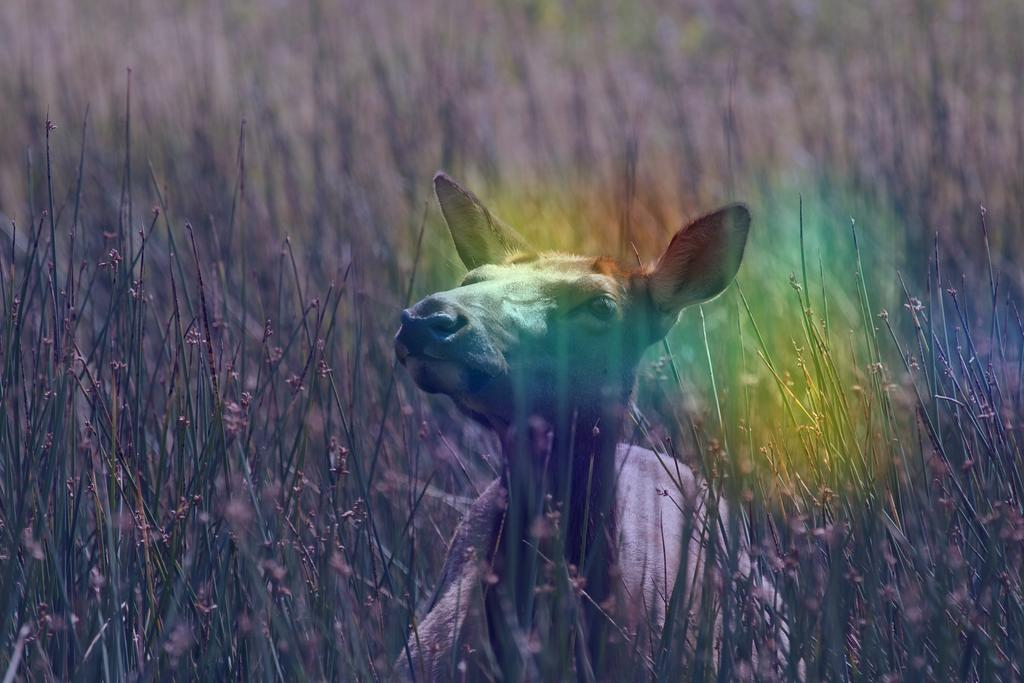

In [34]:
grad_cam_img_path = 'dataset/train/elk/EDF9.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

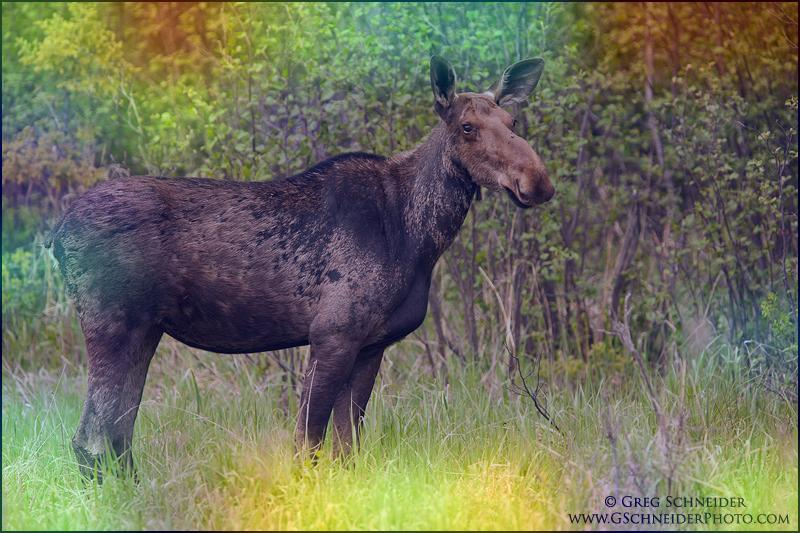

In [35]:

grad_cam_img_path = 'dataset/train/moose/female_moose (23).jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

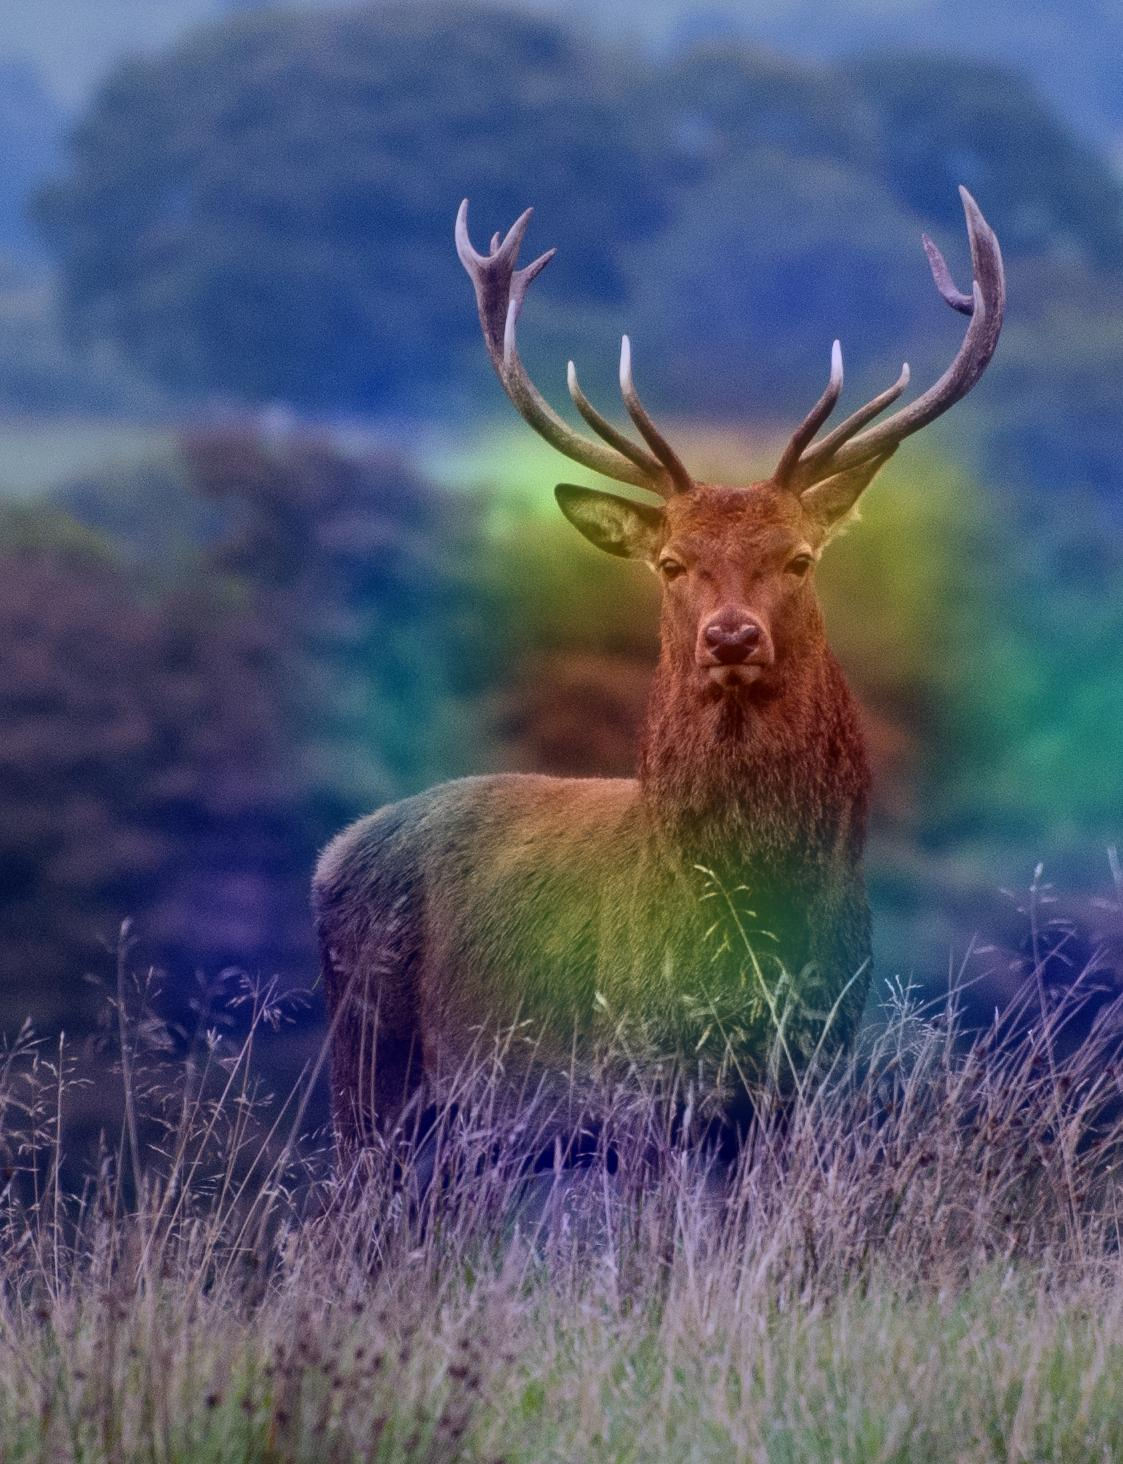

In [36]:
grad_cam_img_path = 'dataset/test/deer/red_deer_00044.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

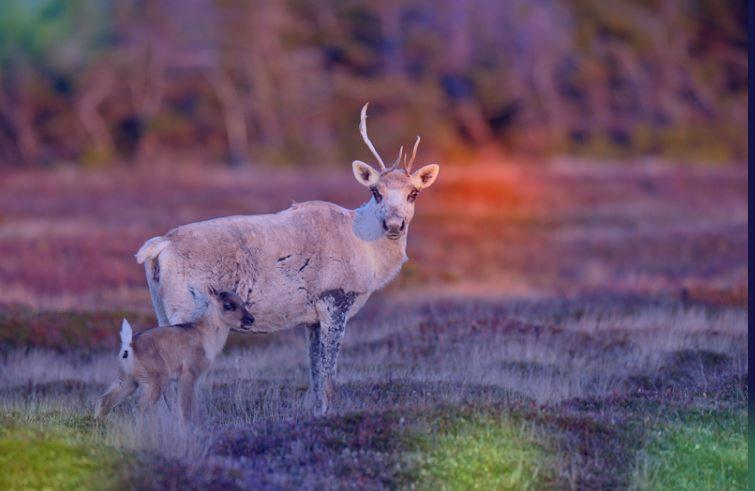

In [37]:
grad_cam_img_path = 'dataset/train/caribou/Female_Caribou91.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

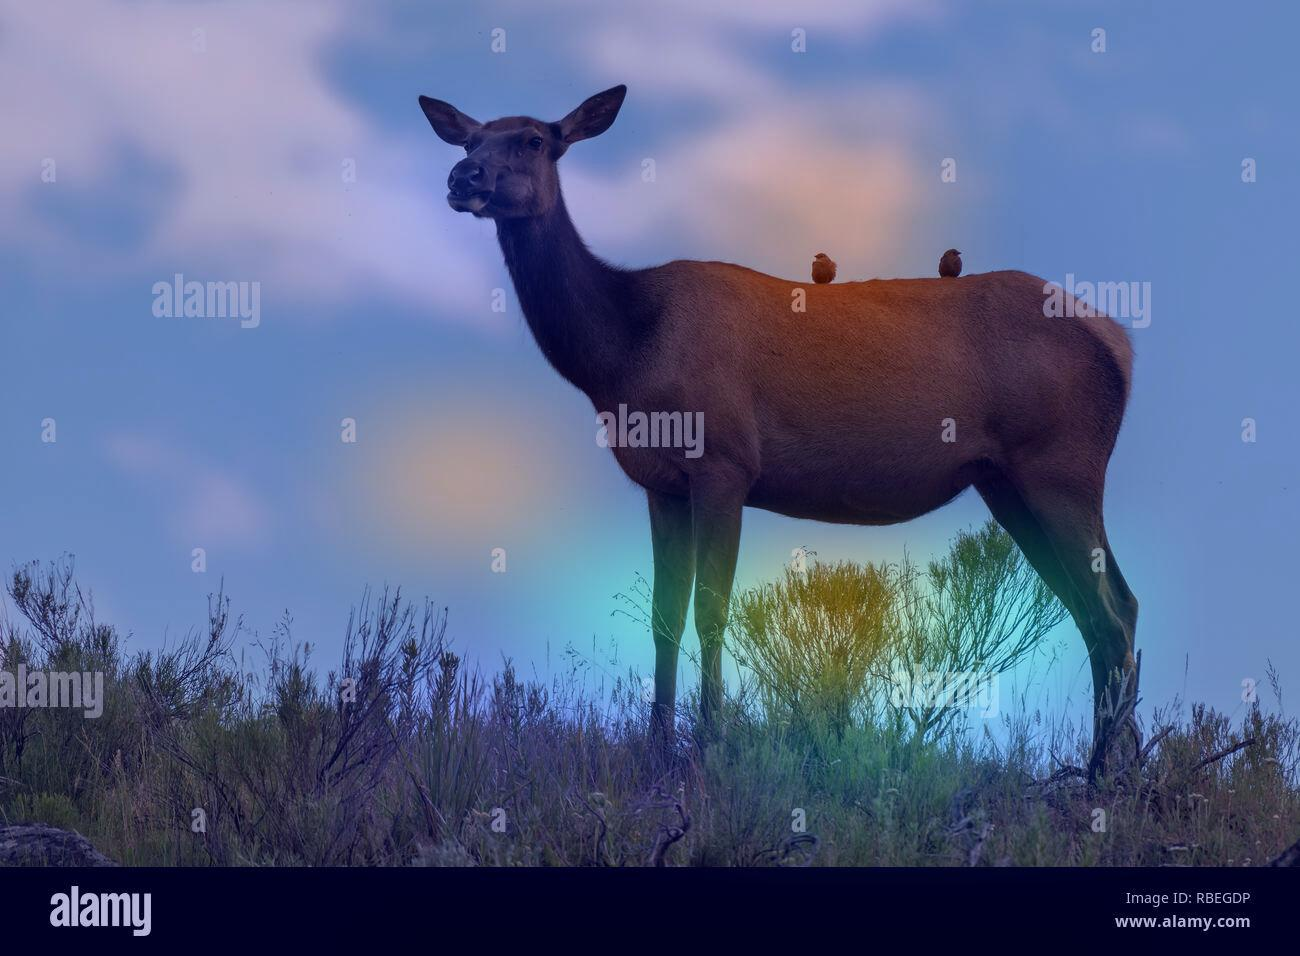

In [38]:
grad_cam_img_path = 'dataset/train/elk/EDF78.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

2023-11-04 22:59:17.248830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 23s 23s/step


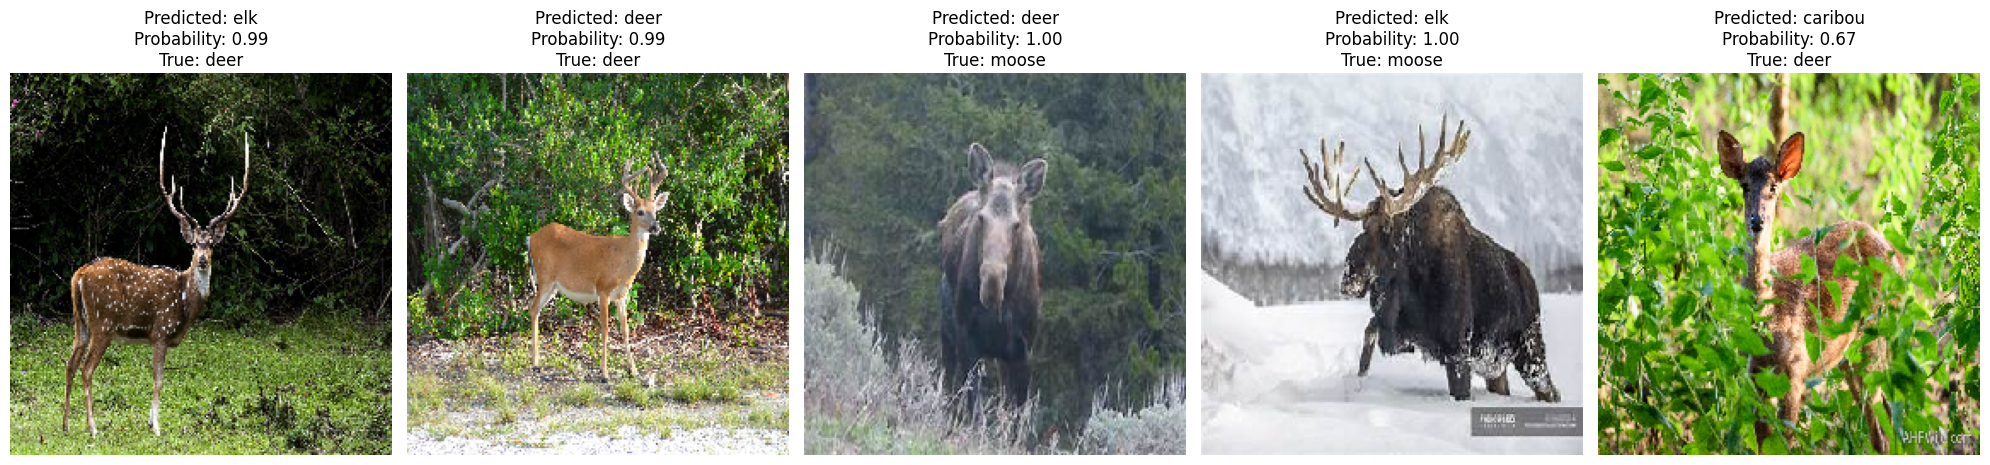

In [39]:
test_images_directory = 'dataset/test/'
class_name = {0:'caribou',1:'deer',2:'elk',3:'moose'}
show_predicted_img(model,test_images_directory,class_name)

In [40]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image, label in test_dataset:
   # append true labels
   y_true.append(label)
   # compute predictions
   preds = model.predict(image)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 150ms/step


Text(0.5, 1.0, 'ResNet152V2')

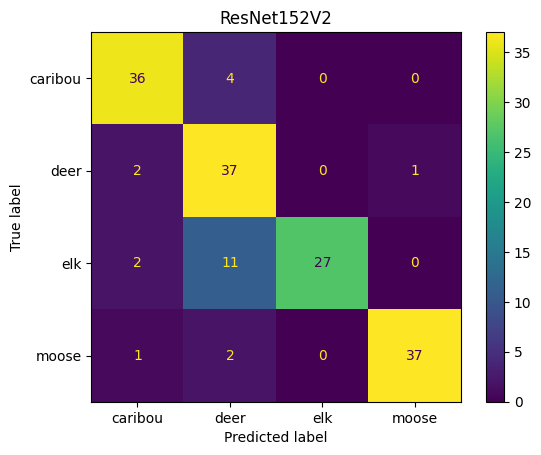

In [41]:
label = ["caribou","deer","elk","moose"]
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels,display_labels=label)
plt.title("ResNet152V2")

In [42]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        40
           1       0.69      0.93      0.79        40
           2       1.00      0.68      0.81        40
           3       0.97      0.93      0.95        40

    accuracy                           0.86       160
   macro avg       0.88      0.86      0.86       160
weighted avg       0.88      0.86      0.86       160



2023-11-04 23:00:07.212603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 21s 21s/step


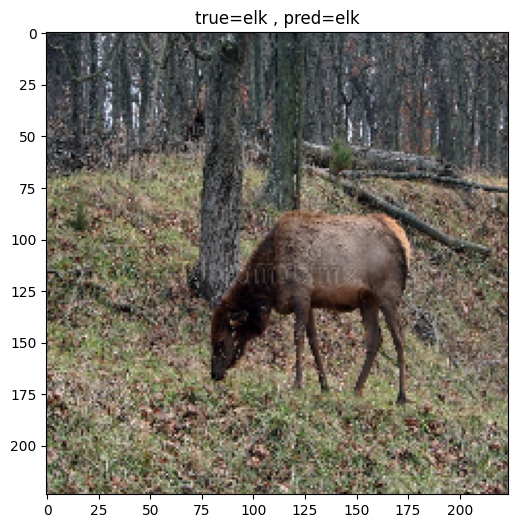

In [43]:
"""
dataset/test/caribou/Male_Caribou8.jpg
dataset/test/elk/EDF91.jpg
dataset/test/moose/male_moose (86).jpg
dataset/test/deer/white_tailed_deer_00019.jpg
"""
img_path = 'dataset/test/elk/EDF91.jpg'
model_path = 'resnet_callback/train_conv5_bestmodel_epoch63_nopool_valloss0.29.h5'
load_resnet_trained = tf.keras.models.load_model(model_path)
label_dict = {0:"caribou",1:"deer",2:"elk",3:"moose"}
y_true = img_path.split("/")
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
array = tf.keras.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)
x = preprocess_input(array)
preds = load_resnet_trained.predict(x)
y_pred = np.argmax(preds)
plt.figure( figsize=(12,6))
ax = plt.gca()
plt.imshow(img)
plt.title( f"true={y_true[2]} , pred={label_dict[y_pred]}" )
plt.show()

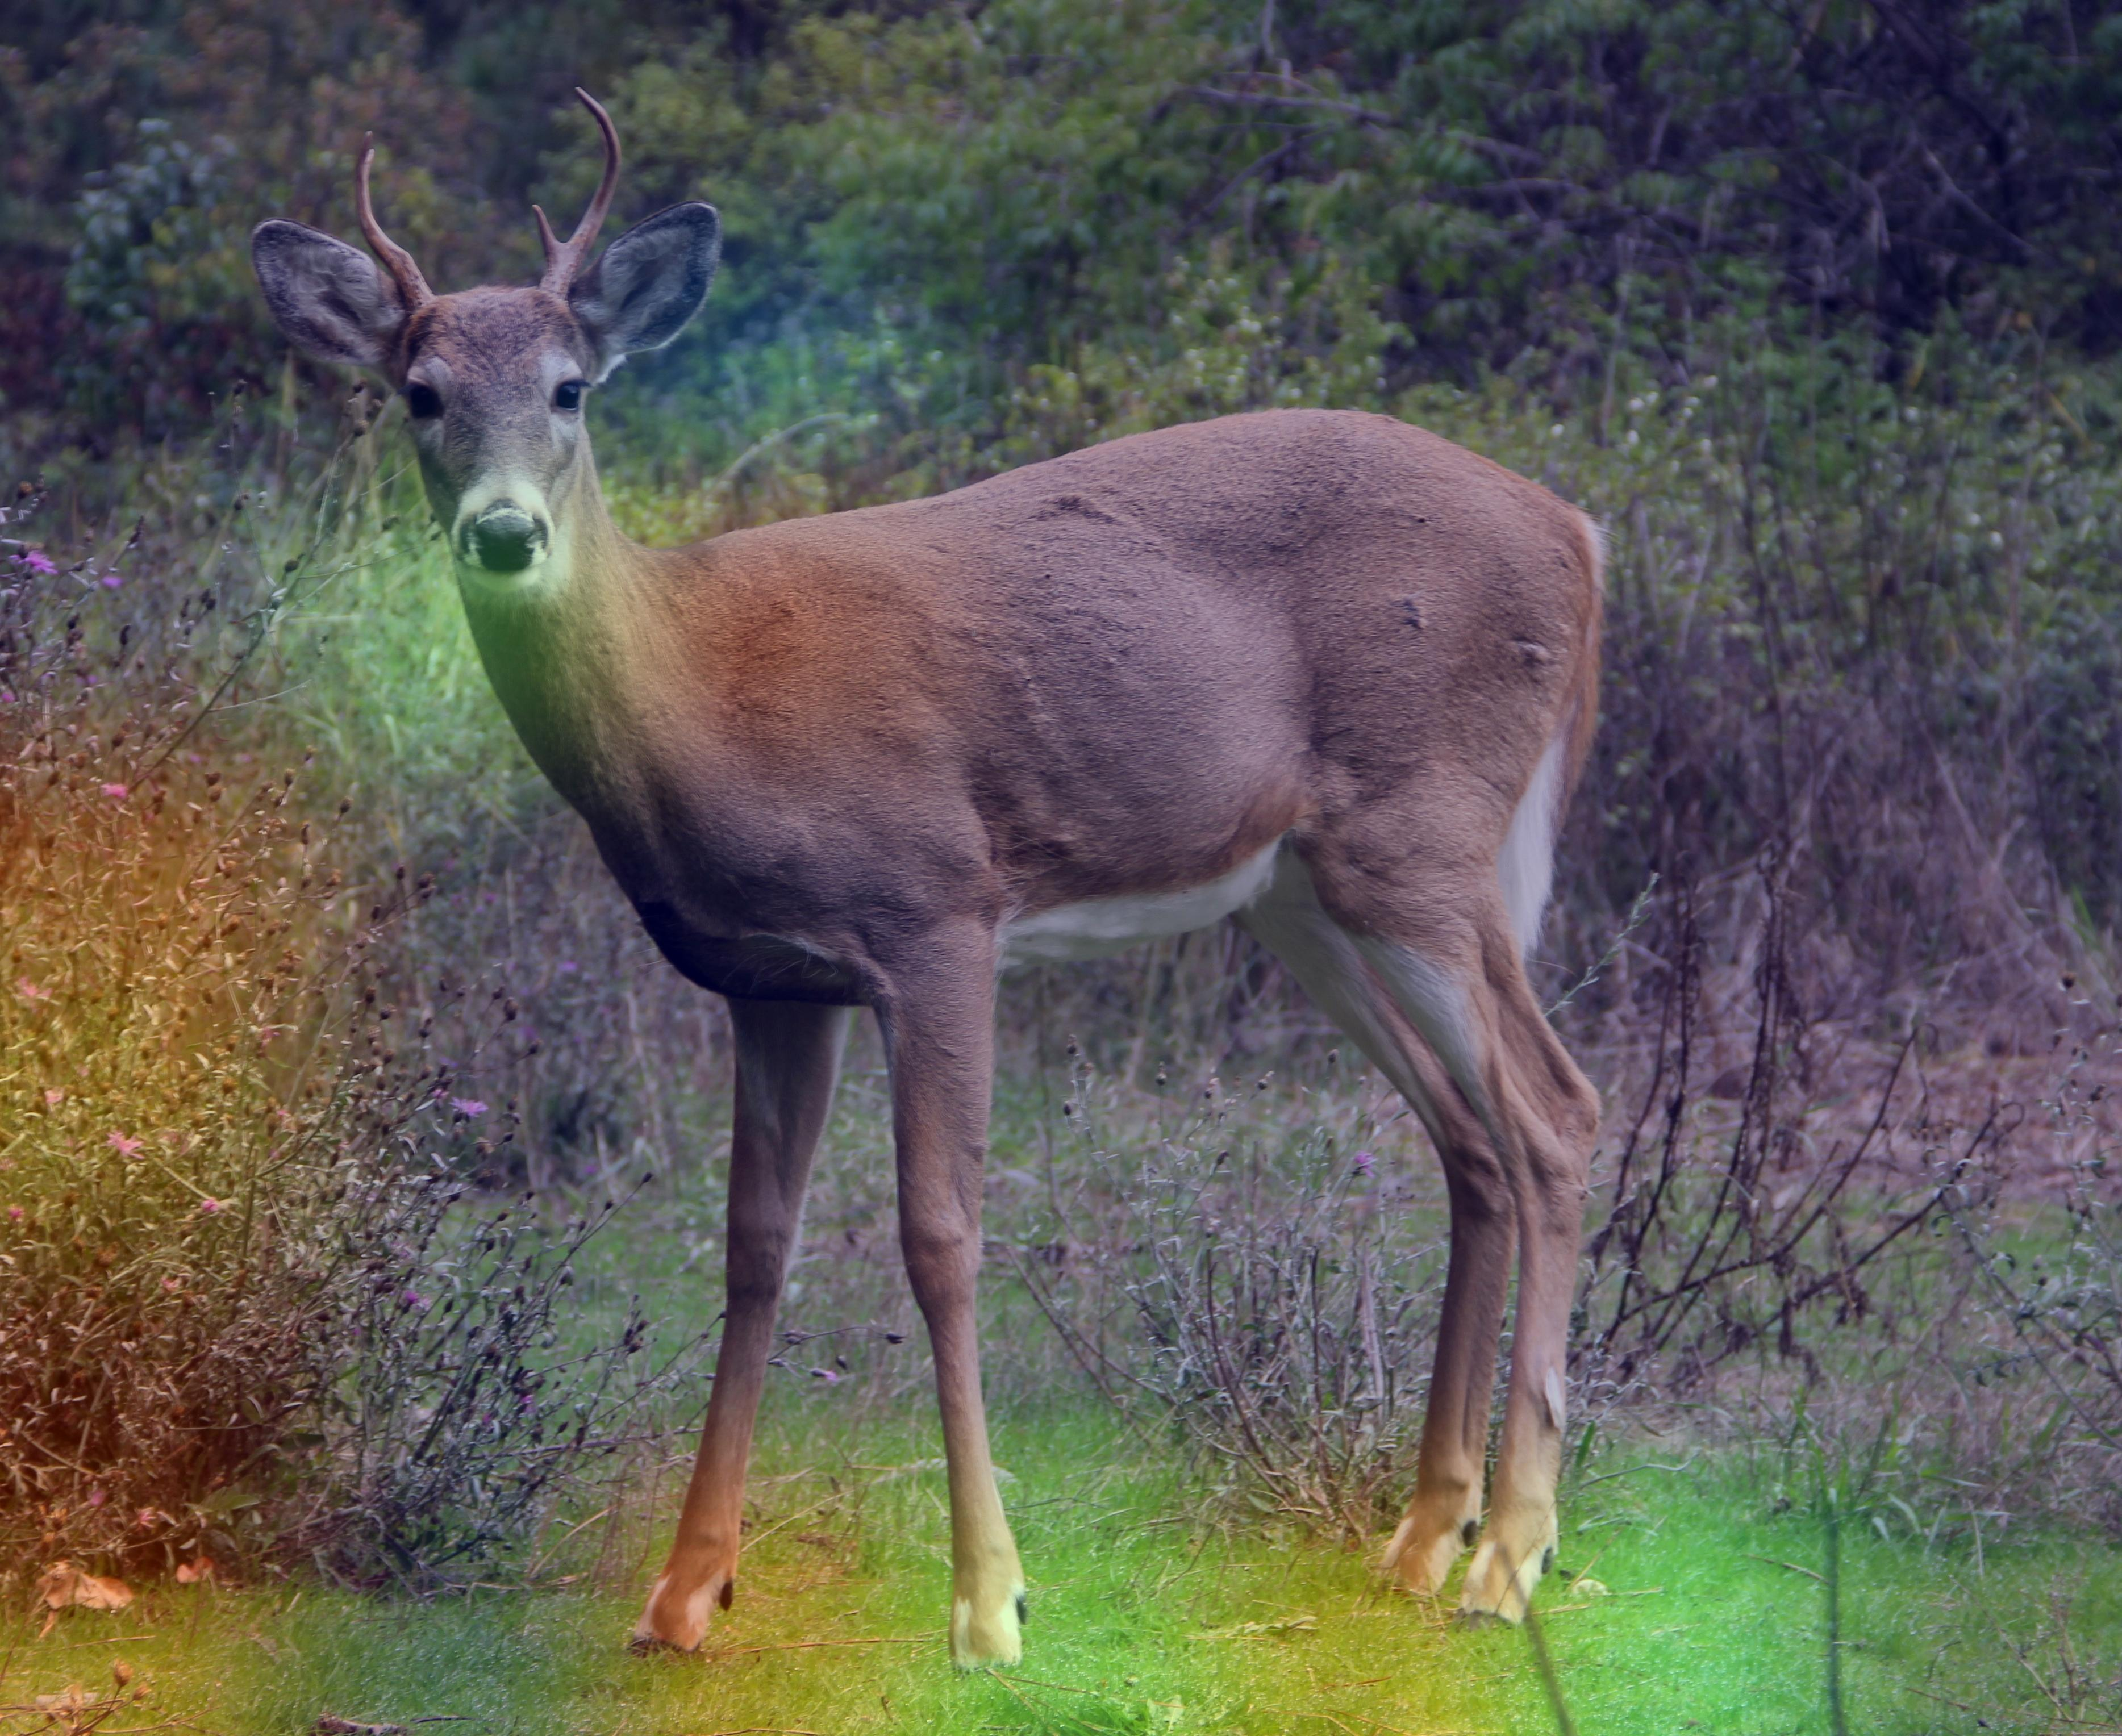

In [44]:
"""
dataset/test/caribou/Male_Caribou8.jpg
dataset/test/elk/EDF91.jpg
dataset/test/moose/male_moose (86).jpg
dataset/test/deer/white_tailed_deer_00019.jpg
"""
last_conv_layer_name = "conv5_block3_out"
grad_cam_img_path = 'dataset/test/deer/white_tailed_deer_00019.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), loaded_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)